# Wasserstein GAN With Gradient Penalty

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.15.0'

# Loading & Preprocessing

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
buffer_size = 60000
batch_size = 256
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.10569309, -1.1044288 , -0.53367597, -2.2459028 , -0.39933085,
        -0.08131311, -0.16309226, -0.46278226, -0.44105142, -1.0374398 ,
        -2.050301  ,  1.2104968 ,  0.786533  ,  0.8915149 , -1.1751547 ,
        -1.0039334 ,  1.0257025 , -0.9492954 , -0.64301157, -0.06766096,
         1.0792742 , -0.50205857, -0.13434498, -0.66601455, -1.5203493 ,
        -1.68264   ,  0.4021831 ,  0.75442857,  0.2216952 ,  1.4822607 ,
         0.99000895,  0.21260999,  0.16333683,  1.4314725 ,  0.5372211 ,
         0.34856737, -0.47444853, -2.614623  ,  0.3871474 , -0.09863069,
        -1.050167  , -0.073764  , -0.58121574,  0.04912575, -2.5872378 ,
         0.34925938, -0.26254234,  1.0175482 , -1.1653805 ,  0.923769  ,
        -1.2709098 , -0.44602537, -0.55716884,  1.7746499 ,  0.0646017 ,
        -1.1308258 ,  1.2584392 , -0.21698721,  0.2105544 , -0.14947428,
         0.8357323 , -0.5533838 , -1.3603982 ,  0.7734854 ,  1.3202662 ,
 

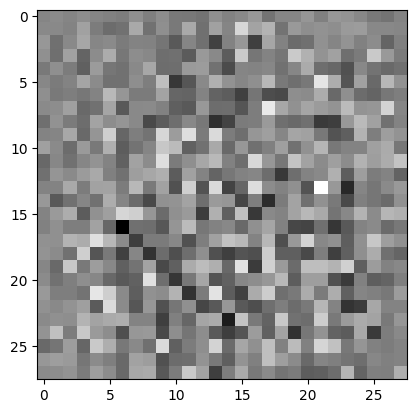

In [ ]:
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :,:,0], cmap='gray');

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
def loss_generator(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output)
  return g_loss

In [ ]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
epochs = 50
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [ ]:
def training_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = loss_generator(fake_output)
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [ ]:
def create_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        training_step(img_batch)
    #display.clear_output(wait = True)
    create_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))

  #display.clear_output(wait = True)
  create_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

In [ ]:
train(X_train, epochs)

Output hidden; open in https://colab.research.google.com to view.

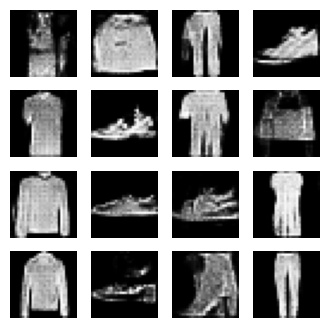

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')